# Portfolio Regression Analysis
```Run Environment: conda tej (python 3.8)```
📈
🎄
❄
😢
⛄

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

from utils import *
from rolling import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from scipy.stats import shapiro, anderson

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import gc, pickle, datetime, warnings
warnings.filterwarnings('ignore')

## 1. Data
- **Datas**
    - `revenue_strategy` daily data from TEJ revenue strategy
    - `cross_section_stock` daily data from TEJ data preprocess
    - `cross_section_integrate_stock` daily data with columns from both the above data
    - `clean_weekly_data` data cleaned with missing values, ..., but no transforming data. 
        - Read as `data_preprocess`
        - This is the data input of rolling prediction
        - Transform data set in rolling prediction section
- Columns
    - ROI | return


### 1.1 Get from TEJ API 
#### need industry data!
> DO NOT run this cell UNLESS need more data from tej api

1.1.0 Setup for tej api key, env, etc.

In [3]:
import pandas as pd
import datetime
import os
import pickle
# set tej_key and base
tej_key = "42ZX84O9jUiap5JOlFABw2XxklwYgY"
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key
os.environ['TEJAPI_BASE']= api_base

import numpy as np
import tejapi
import TejToolAPI 
from zipline.data import bundles


tejapi.ApiConfig.api_key = tej_key  
tejapi.ApiConfig.api_base = api_base

# set date
start='2023-01-01'
end='2023-10-24'

from logbook import Logger, StderrHandler, INFO
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('get_universe')

1.1.1 Tickers
- 以下兩種方式皆能取得曾經上市+上櫃的普通股（不含F股或KY股）：
  - `get_universe(start, end, mkt=['TWSE','OTC'], stktp_c=['普通股'])`
  - `get_universe(start, end, mkt_bd_e=['TSE','OTC','TIB'], mkt=['TWSE','OTC'], stktp_c=['普通股'])`

In [ ]:
from zipline.sources.TEJ_Api_Data import get_universe
tickers = get_universe(start, end, mkt=['TWSE','OTC'], stktp_c=['普通股'])
os.environ['mdate'] = '20000103 20231220'

with open("data/tickers.pk", "wb") as f:
    pickle.dump(tickers, f)


In [30]:
# load
with open("data/tickers.pk", "rb") as f:
    tickles = pickle.load(f)

1.1.2 Define Columns

`# TEJ-Tool-API`
- File in [TEJ github](https://github.com/tejtw/TQuant-Lab) ==> 
[Data Preprocess](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)\
- columns from: 
    - list below 
    - revenue strategies' columns
- Note that length of columns list specified do not equal to the downloaded data

In [4]:
# 月營收的欄位
columns_rev = ['Sales_Accu_LastYear', 'Sales_Accu_3M',
       'Sales_Per_Share_Accu_12M', 'YoY_Accu_Sales', 'YoY_Monthly_Sales',
       'Sales_Per_Share_Accu_3M', 'Sales_Accu_3M_LastYear', 'Sales_Monthly',
       'YoY_AccuSales_12M', 'YoY_Accu_Sales_3M', 'MoM_Monthly_Sales',
       'Sales_Accumulated', 'QoQ_Accu_Sales_3M', 'MoM_Accu_Sales_3M',
       'Sales_Monthly_LastYear', 'Outstanding_Shares_1000_Shares']

# 量化籌碼_周 - 集保庫存欄位
columns_chip_week = ['Total_Custodied_Shares_1000_Lots',
       'Custodied_Under_400_Lots_Total_Lots',
       'Custodied_Lots_Between_800_1000_Total_Lots',
       'Custodied_Larger_Than_400_Lots_Pct',
       'Custodied_Lots_Between_400_600_Total_Lots',
       'Custodied_Lots_Between_600_800_Pct', 'Pledged_Stock_Shares_1000_Lots',
       'Custodied_Under_400_Lots_Pct',
       'Custodied_Lots_Between_400_600_Total_Holders',
       'Custodied_Lots_Between_800_1000_Total_Holders',
       'Custodied_Under_400_Lots_Total_Holders',
       'Custodied_Lots_Between_400_600_Pct',
       'Custodied_Lots_Between_800_1000_Pct',
       'Custodied_Greater_Than_1000_Lots_Pct']

# 量化籌碼_日& 交易註記 欄位
columns_chip_day =['Market', 'Dealer_Proprietary_Diff_Vol', 'Margin_Sale',
       'Cash_Redemption', 'Margin_Short_Balance_Amt',
       'Margin_Short_Balance_Vol', 'Dealer_Hedge_Buy_Vol',
       'Day_Trading_Volume_1000_Shares', 'SBL_Short_Returns_Vol',
       'Margin_Maintenance_Ratio', 'Account_Maintenance_Ratio',
       'Margin_Stock_Redemtion', 'Total_Sell_Amt',
       'Margin_Short_Maintenance_Ratio', 'SBL_Short_Balance_Vol',
       'Dealer_Hedge_Buy_Amt', 'Total_Buy_Amt', 'Total_Diff_Amt',
       'Fund_Diff_Vol', 'Dealer_Proprietary_Buy_Vol',
       'Dealer_Proprietary_Sell_Amt', 'Margin_Day_Trading_Amt',
       'Total_Diff_Vol', 'SBL_Short_Sales_Vol', 'SBL_Short_Balance_Amt',
       'Dealer_Stock_Holding_Pct', 'Dealer_Hedge_Sell_Vol', 'Qfii_Buy_Vol',
       'Qfii_Stock_Holding_Pct', 'Qfii_Sell_Vol', 'Fund_Stock_Holding_Pct',
       'Dealer_Proprietary_Buy_Amt', 'Dealer_Hedge_Diff_Amt', 'Qfii_Sell_Amt',
       'Margin_Day_Trading_Vol', 'Fund_Sell_Amt', 'Day_Trading_Pct',
       'Margin_Short_Sales', 'Fund_Diff_Amt', 'Margin_Balance_Ratio',
       'SBL_Short_Sales_Amt', 'Fund_Buy_Vol', 'Qfii_Buy_Amt',
       'Margin_Balance_Vol', 'Qfii_Diff_Vol', 'Margin_Purchase',
       'Dealer_Hedge_Sell_Amt', 'Dealer_Proprietary_Sell_Vol', 'Fund_Sell_Vol',
       'Margin_Quota', 'Qfii_Diff_Amt', 'Total_Sell_Vol', 'Margin_Short_Quota',
       'Margin_Short_Coverting', 'Fund_Buy_Amt', 'Dealer_Proprietary_Diff_Amt',
       'Total_Buy_Vol', 'Margin_Balance_Amt', 'SBL_Short_Quota',
       'Dealer_Hedge_Diff_Vol', 'Component_Stock_of_TPEx200_Fg', 'Industry',
       'Component_Stock_of_MSCI_TW_Fg', 'Component_Stock_of_High_Dividend_Fg',
       'Security_Type_Chinese', 'Suspension_of_Buy_After_Day_Trading_Fg',
       'Matching_Period', 'Component_Stock_of_TWN50_Fg',
       'Component_Stock_of_MidCap100_Fg', 'Suspended_Trading_Stock_Fg',
       'Market_Board', 'Full_Delivery_Stock_Fg', 'Disposition_Stock_Fg',
       'Security_Type_English', 'Attention_Stock_Fg', 'Industry_Eng',
       'Component_Stock_of_TPEx50_Fg', 'Limit_Up_or_Down_in_Opening_Fg',
       'Limit_Up_or_Down']

# 價量與籌碼
# Adj prc = Close (Open) * Adjust Factor
columns_prc_chips = ['Open','High','Low','Close','Adjust_Factor','Volume_1000_Shares','Value_Dollars'
           'Transaction','Last_Bid','Last_Offer','Average_Trade_Price','ROI','High_Low_Diff','Turnover'
           'Issue_Shares_1000_Shares','Market_Cap_Dollars','Market_Cap_Percentage','Trade_Value_Percentage'
           'PER_TWSE','PBR_TWSE','Dividend_Yield_TWSE','Cash_Dividend_Yield_TEJ',
           'Qfii_Buy_Vol','Qfii_Sell_Vol','Qfii_Diff_Vol','Qfii_Buy_Amt','Qfii_Sell_Amt','Qfii_Diff_Amt','Qfii_Stock_Holding_Pct','Fund_Buy_Vol',
           'Fund_Sell_Vol','Fund_Diff_Vol','Fund_Buy_Amt','Fund_Sell_Amt','Fund_Diff_Amt','Fund_Stock_Holding_Pct','Dealer_Proprietary_Buy_Vol','Dealer_Proprietary_Sell_Vol','Dealer_Proprietary_Diff_Vol','Dealer_Proprietary_Buy_Amt',
           'Dealer_Proprietary_Sell_Amt','Dealer_Proprietary_Diff_Amt','Dealer_Hedge_Buy_Vol','Dealer_Hedge_Sell_Vol','Dealer_Hedge_Diff_Vol','Dealer_Hedge_Buy_Amt','Dealer_Hedge_Sell_Amt','Dealer_Hedge_Diff_Amt',
           'Dealer_Stock_Holding_Pct','Total_Buy_Vol','Total_Sell_Vol','Total_Diff_Vol','Total_Buy_Amt','Total_Sell_Amt','Total_Diff_Amt'
            ]

# 財務類別
fin_type = ['A','Q','TTM']

# 財務資料 - 財務僅會計師核閱
columns_comp_finance =['Total_Operating_Cost','Sales_Per_Share','Return_Rate_on_Equity_A_percent',
       'Proceeds_from_Disposal_of_Fixed_and_Intangible_Assets',
       'Cash_Flow_from_Operating_Activities', 
       'Other_Adjustment_from_Operating_Activities', 'Borrowings',       
       'Total_Operating_Expenses', 'Gross_Margin_Rate_percent',
       'Sales_Growth_Rate', 'Net_Income_Per_Share','Total_Assets',
       'Short_Term_Borrowings_Financial_Institutions',
       'Pre_Tax_Income_Growth_Rate', 'Total_Equity_Growth_Rate',
       'Total_Operating_Income','Total_Assets_Turnover',
       'Operating_Income_Per_Share','Pre_Tax_Income_Rate_percent', 
       'Gross_Profit_Loss_from_Operations','Return_on_Total_Assets',
       'Depreciation_and_Amortisation','Total_Interest_Income',
       'Fixed_Asset_Turnover', 'Decrease_Increase_in_Prepayments']

# 財務資料 - 財務包含公司自結數與會計師核閱
columns_comp_finance_2 =['Total_Operating_Cost','Sales_Per_Share','Return_Rate_on_Equity_A_percent',
       'Proceeds_from_Disposal_of_Fixed_and_Intangible_Assets',
       'Cash_Flow_from_Operating_Activities', 
       'Other_Adjustment_from_Operating_Activities', 'Borrowings',       
       'Total_Operating_Expenses', 'Gross_Margin_Rate_percent',
       'Sales_Growth_Rate', 'Net_Income_Per_Share','Total_Assets',
       'Short_Term_Borrowings_Financial_Institutions',
       'Pre_Tax_Income_Growth_Rate', 'Total_Equity_Growth_Rate',
       'Total_Operating_Income','Total_Assets_Turnover',
       'Operating_Income_Per_Share','Pre_Tax_Income_Rate_percent', 
       'Gross_Profit_Loss_from_Operations','Return_on_Total_Assets',
       'Depreciation_and_Amortisation','Total_Interest_Income',
       'Fixed_Asset_Turnover', 'Decrease_Increase_in_Prepayments',]


In [10]:
# define columns
columns = columns_rev + columns_prc_chips + columns_comp_finance

# check if duplicated in columns
if [item for item in columns if columns.count(item) > 1] != []:
    print("duplicated columns!")
    columns = set(columns)

# len columns
len(columns)

93

In [11]:
# check the columns diff between revenue and cross section
# already ran below. don't run again
# store diff in data/col_diff_cross_revenue.pk
"""
with open(f"data/cross_section_stock.pk", "rb") as f:
    data_cross_section = pickle.load(f)
# use csv
# data_bundled = pd.read_csv('data/revenue_bundled.csv')
with open(f"data/revenue_strategy.pk", "rb") as f:
    data_revenue = pickle.load(f)

# check columns b
col_diff = []

for col in data_revenue.columns:
    print(col)
    if col not in list(data_cross_section.columns):
        col_diff.append(col)
"""

# load columns iff
with open('data/col_diff_cross_revenue.pk', 'rb') as f:
    col_diff = pickle.load(f)

# cross sec columns + revenue columns 
columns += col_diff

In [12]:
len(columns)

118

In [13]:
# get data from tej api
ticker = tickers
data = TejToolAPI.get_history_data(ticker=ticker, 
                                   columns=columns,
                                   transfer_to_chinese=False,
                                   fin_type=fin_type,
                                   include_self_acc='N' 
                                  )
data 

,coid,mdate,Industry_Eng,Last_Bid,Volume_1000_Shares,PBR_TWSE,Dividend_Yield_TWSE,Cash_Dividend_Yield_TEJ,Open,Close,...,Total_Assets_TTM,Total_Interest_Income_A,Total_Interest_Income_Q,Total_Interest_Income_TTM,Sales_Growth_Rate_A,Sales_Growth_Rate_Q,Sales_Growth_Rate_TTM,Total_Operating_Cost_A,Total_Operating_Cost_Q,Total_Operating_Cost_TTM
0,1101,2021-01-04,M1100 Cement,43.20,13744.0,1.32,6.94,5.4473,43.20,43.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1101,2021-01-05,M1100 Cement,43.10,16631.0,1.32,6.96,5.4599,43.25,43.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1101,2021-01-06,M1100 Cement,42.90,19007.0,1.32,6.98,5.4790,43.10,42.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1101,2021-01-07,M1100 Cement,42.85,21050.0,1.31,7.00,5.4918,42.95,42.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1101,2021-01-08,M1100 Cement,42.90,17406.0,1.32,6.98,5.4790,42.90,42.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190324,9962,2023-12-14,OTC20 OTC Steel,17.60,87.0,1.40,10.20,10.1983,17.65,17.65,...,1528384.0,878.0,6.0,1389.0,1.09,1.95,10.91,2366081.0,793009.0,3215571.0
1190325,9962,2023-12-15,OTC20 OTC Steel,19.00,4147.0,1.50,9.47,9.4737,17.70,19.00,...,1528384.0,878.0,6.0,1389.0,1.09,1.95,10.91,2366081.0,793009.0,3215571.0
1190326,9962,2023-12-18,OTC20 OTC Steel,18.70,2835.0,1.48,9.60,9.6000,19.15,18.75,...,1528384.0,878.0,6.0,1389.0,1.09,1.95,10.91,2366081.0,793009.0,3215571.0
1190327,9962,2023-12-19,OTC20 OTC Steel,18.40,871.0,1.45,9.78,9.7826,18.85,18.40,...,1528384.0,878.0,6.0,1389.0,1.09,1.95,10.91,2366081.0,793009.0,3215571.0


In [ ]:
"""
columns = ['Industry_Eng']
ticker = tickers
data_i = TejToolAPI.get_history_data(ticker=ticker, 
                                   columns=columns,
                                   transfer_to_chinese=False,
                                   fin_type=fin_type,
                                   include_self_acc='N' 
                                  )
data_i 
"""

revenue strategy


`columns = ['Industry_Eng','開盤價','收盤價', 'roi', 'YoY_Monthly_Sales', 'eps', '外資買賣超金額_元','營業毛利率', '營業利益率', '稅後淨利率', '業外收支率', '營收成長率', '營業毛利成長率', '營業利益成長率', '稅後淨利成長率', '淨值成長率','Inventories', 'mktcap']`

`data = TejToolAPI.get_history_data(ticker=tickers, columns=columns, transfer_to_chinese=False, start = '2013-01-01', end = '2023-07-24')`

`data = data.sort_values(['coid','mdate'])`


Store data

In [14]:
# store data
# data
# 1. cross section stock: only columns from {columns_rev + columns_prc_chips + columns_comp_finance}
# 2. revenue strategy stock : from revenue strategy in TEJ document
# 3. cross section integrate stock: combine data above
import pickle
with open("data/cross_section_integrate_stock.pk", "wb") as f:
    pickle.dump(data, f)

# Store in pc and database
import sqlalchemy
import pickle
from sqlalchemy import create_engine, VARCHAR
host = 'localhost'
port = "3306"
user = 'root'
pwd = 'test123'
database_name = 'tej'
con = create_engine('mysql+pymysql://'+user+':'+pwd+'@'+host+':'+port+'/'+database_name)


table_name = "cross_section_integrate_stock"
data.to_sql(table_name, con=con, if_exists='replace')

### 1.2 Load Data Stored in PC 
- ⛄ 1.2.0 **DO NOT NEED TO RUN 1.3** If load cleaned data: 'data\clean_data\clean_weekly_data.pk'. 
- ⛄ 1.2.1 data_cross_section
    - `> with open(f"data/cross_section_integrate_stock.pk", "rb") as f:`\
    - `>>     data_cross_section = pickle.load(f)`

1.2.2 Load Clean Data (*No transform data*)
- No need to run 1.3 before 1.3.6 if load data here

In [2]:
with open('data/clean_data/clean_weekly_data.pk', 'rb') as f:
    data_clean = pickle.load(f)

1.2.1 loaod row data
- Need to run 1.3 if load data here

In [2]:
with open(f"data/cross_section_integrate_stock.pk", "rb") as f:
    data_cross_section = pickle.load(f)

`don't run here`\
1.2.3 Database

In [45]:
# Store in pc and database
import sqlalchemy
import pickle
from sqlalchemy import create_engine, VARCHAR
host = 'localhost'
port = "3306"
user = 'root'
pwd = 'test123'
database_name = 'tej'
con = create_engine('mysql+pymysql://'+user+':'+pwd+'@'+host+':'+port+'/'+database_name)
table_name = "cross_section_integrate_stock"

sql_query = f'SELECT * FROM {table_name}'
data_revenue = pd.read_sql(sql_query, con)
data_revenue.drop(columns=["index"], inplace = True)

KeyboardInterrupt: 

### 1.3 Preprocess and Store
- ⛄ 1.3.1 Close tp Adj close 
- ⛄ 1.3.2 Weekly rerturn (for each Friday) 
     - *1. {"0": Monday, "1": ~, ...}* 
- ⛄1.3.3 backup data_week
- ⛄1.3.4 missing value
    - `fill_missing_value_dropna(data)`

- ⛄1.3.5 data bauckup here: data_week_return, data_cross_section
    - *data -> daily*
    - *data_week -> week* 
- ⛄1.3.6 CLEANED DATA
    - *This is CLEANED DATA*


In [3]:
# adj price
data_cross_section = get_adj_close(data_cross_section)

# week data
data_week_return = date_to_week_pipeline(data_cross_section)

# back up data
data_week_backup = data_week_return.copy()
data_backup = data_cross_section.copy()

# miss value
data_preprocess = fill_missing_value_dropna(data_week_return)
print(f'na: {data_preprocess.isna().sum().sum()}')

with open('data/clean_data/clean_weekly_data.pk', 'wb') as f:
    pickle.dump(data_preprocess, f)
    
# standaidise amd winsorise
# skip. weird
# data_preprocess = standardise_winsorise_by_date(data_preprocess)


NameError: name 'data_cross_section' is not defined

## 2. Multiple Linear Model
Take first rolling period data

### Multiple Linear Regression Diagnosis and variable selection - [Colab](https://colab.research.google.com/github/rafiag/DTI2020/blob/main/002a_Multi_Linear_Regression_(EN).ipynb#scrollTo=iVvGlw106ukZ)
- **Preprocess of data**
    - Standardise
    - Winsorise 
- **Linearity**
    - Polynomial and Correlation: use polynomial to create variables with different degree, and select by correlation.
    - *Kernel Method (^)*
    - *Spline (^)*
        - [Splines Elaboration](https://zhuanlan.zhihu.com/p/34825299)
        - [Cubic-Splines Colab](https://colab.research.google.com/github/tgteacher/numerical-methods/blob/master/notebooks/Chapter3.ipynb#scrollTo=SLLvPEzPnYCr): poly interpolation, cubic interpolation, and Newton interpolation

- **Independent of epsilons (residuals)**\
    Since the sample is large, do not have to deal with it.

- **Collinearity**
    - Note from regression
        - [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
        - [2] The condition number is large, 1.6e+16. This might indicate that there are strong multicollinearity or other numerical problems
    - **PCA**

- **Stepwise by BIC**
    - forward
    - To reduce the variance of covariate slope (coefficient)

- **Normality and Homogeneity**
    - Not normal of residuals: [HCCM](https://jslsoc.sitehost.iu.edu/files_research/testing_tests/hccm/00TAS.pdf)
        - <font color=#FF00FF> Why the sm model cov_type = "HC0" do not work </font>
        - HAC (Covarinace type)
        - use HC0 in HCCM, heteroskedasticity consistent covariance matrix, where HC1, HC2, and HC3 are adjustment under small sample.
    - Weighted least square
        - [**NYCU L17 weighted least square 1:16:00**](https://www.youtube.com/watch?v=GAREvGsRjdo&list=PLj6E8qlqmkFu0cY9PfwoFq6SbuZ-M28JE&index=17)
        - <font color=#FF00FF> check weight correctness. The version now is not same as in NYCU class</font>:
         ***ref*** [WLS python](https://www.einblick.ai/python-code-examples/weighted-least-squares-regression-statsmodels/)
        - **To solve problem** | not constant variance on y 
        - **Memory error** | in computing matrices: use 26 weeks data, not 52
        - **Standardise**  | cause inverse failed



### c. Code examples
- **Useful Functions / Classes**
    - `Split_X_y(data)`
    - `fit_linear(X, y)`
    - `graphic_diagnostic(linear_reg)`
    
- **Full Feature Engineering Process**
    ```
    # 1. scale and winsro
    X_scale_winsor = self.feature_eng.transform_standard_winsor(X_train, scale_method='Standard', winsor=True)
    X_test = self.feature_eng.transform_standard_winsor(X_test, scale_method='Standard', winsor=True)

    # 2. poly 
    X_poly = self.feature_eng.transform_poly(X_scale_winsor)
    X_test = self.feature_eng.transform_poly(X_test)

    # 3. selected pearsonr
    X_selected_corr, selected_col_corr = self.feature_eng.selected_pearsonr(X_poly, y_train)
    X_test = self.feature_eng.selected_pearsonr(X_test, None, selected_col_corr)

    # 4. pca
    X_pca, X_test = self.feature_eng.transform_pca(X_selected_corr, X_test, var = 100)

    # 5. selected bic
    X_selected_bic = self.feature_eng.selected_bic(X_pca, y_train)
    X_test = self.feature_eng.selected_bic(X_test, None, selected_col_corr)
    
    # 6. fit models
    linear = fit_linear(sm.add_constant(X_selected_bic), y_train, "HC0")
    linear = build_wls(sm.add_constant(X_selected_bic), y_train, "HC0")
    ```

##### **Time setting, Divide Data into X and y**

In [4]:
from utils import *

# Check `columns type != float`
for i in data_clean.columns:
    if data_clean[i].dtypes != np.float64:
        print(i)

# Train test period size
train_size = 10 # weeks
start_train_date = min(data_clean.reset_index()["mdate"])

# Train test data
train, test, start_train_date, start_test_date = update_data(data_clean, start_train_date, train_size)


# split X, y
X_train, y_train = split_X_y(train)
X_test, y_test = split_X_y(test)


coid
mdate
Industry_Eng


### 2.2 Fit Linear Regression and Check the Assumption of Lienar Model

##### 2.2.1 Normality and Homogeneity


- Not normal

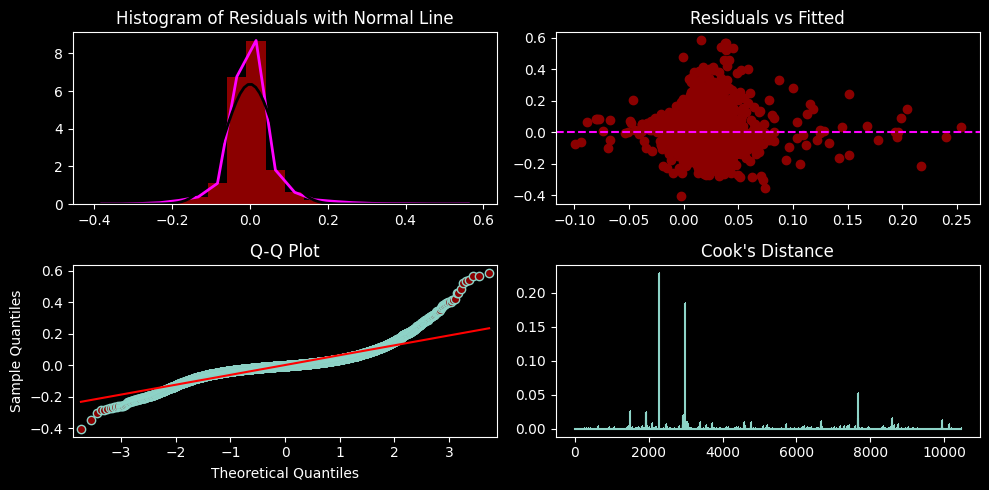

Dep. Variable:,return,R-squared:,0.042
Model:,OLS,Adj. R-squared:,0.032
Method:,Least Squares,F-statistic:,4.199
Date:,"Tue, 26 Dec 2023",Prob (F-statistic):,2.74e-42
Time:,15:30:21,Log-Likelihood:,14120.
No. Observations:,10447,AIC:,-2.802e+04
Df Residuals:,10339,BIC:,-2.724e+04
Df Model:,107,,
Covariance Type:,nonrobust,,


In [7]:
linear_reg = build_ols(X_train, y_train)
graphic_diagnostic(linear_reg)
linear_reg.summary().tables[0]

##### 2.2.2 Linearity

##### 2.2.3 Independent of Epsilon 

- Large data => ignore this

### 2.3 Adjustment and Feature engineer

##### 2.3.2 Feature Engineering

In [8]:
X_train.head(2)

Last_Bid  Volume_1000_Shares  PBR_TWSE  Dividend_Yield_TWSE  \
coid mdate                                                                     
1101 2021-05-14      49.6             38504.0      1.43                 7.06   
     2021-05-21      51.2             29217.0      1.48                 6.84   

                 Cash_Dividend_Yield_TEJ  Open  Close  Average_Trade_Price  \
coid mdate                                                                   
1101 2021-05-14                   6.8538  49.6   49.6              49.7253   
     2021-05-21                   6.6396  53.9   51.2              51.8753   

                    ROI  High_Low_Diff  ...  Total_Interest_Income_A  \
coid mdate                              ...                            
1101 2021-05-14  0.8130         2.0325  ...                 354116.0   
     2021-05-21  0.7874         6.1024  ...                 354116.0   

                 Total_Interest_Income_Q  Total_Interest_Income_TTM  \
coid mdate                                                            
1101 2021-05-14                 354116.0                  1424263.0   
     2021-05-21                 354116.0                  1424263.0   

                 Sales_Growth_Rate_A  Sales_Growth_Rate_Q  \
coid mdate                                                  
1101 2021-05-14                 0.28                 11.3   
     2021-05-21                 0.28                 11.3   

                 Sales_Growth_Rate_TTM  Total_Operating_Cost_A  \
coid mdate                                                       
1101 2021-05-14                  -1.45              16512812.0   
     2021-05-21                  -1.45              16512812.0   

                 Total_Operating_Cost_Q  Total_Operating_Cost_TTM  Adj Close  
coid mdate                                                                    
1101 2021-05-14              16512812.0                79500488.0  40.548050  
     2021-05-21              16512812.0                79500488.0  41.856051  

[2 rows x 129 columns]

In [9]:
fe = feature_engineer()
X_scale_winsor = fe.transform_standard_winsor(X_train, scale_method='Standard', winsor=True)

In [20]:
X_poly = fe.transform_poly(X_scale_winsor)

start create polynomial


In [21]:
X_selected_corr, selected_col = fe.selected_pearsonr(X_poly, y_train)

selecting variable with corr
selected col poly corr: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 53, 54, 56, 74, 75, 76, 80, 81, 83, 84, 86, 87, 88, 92, 93, 95, 96, 98, 99, 100, 101, 102, 103, 110, 111, 113, 114, 115, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 142, 145, 147, 148, 150, 151, 152, 153, 156, 159, 162, 163, 165, 166, 168, 170, 172, 173, 174, 175, 176, 177, 185, 189, 197, 198, 199, 200, 201, 202, 203, 204, 205, 215, 216, 217, 221, 222, 223, 227, 228, 229, 257, 258, 259, 262, 263, 264, 265, 266, 267, 268, 270, 272, 273, 274, 275, 276, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 296, 297, 298, 300, 301, 302, 303, 304, 305, 309, 310, 313, 316, 319, 321, 325, 326, 327, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 349, 350, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362, 36

In [ ]:
l = build_ols(X_selected_corr, y_train)
# Strong collineraity here
l.summary()

In [ ]:
X_pca, X_test = fe.transform_pca(X_selected_corr, X_test=None, var = int(X_selected_corr.shape[1]/10))

In [ ]:
l = build_ols(X_pca, y_train)
# No Collinerity
l.summary()

In [ ]:
X_selected_bic, selected_col = fe.selected_bic(X_pca, y_train)
"""
X_selected_bic = X_pca[:, [83, 31, 57, 96, 30, 84, 68, 40, 70]]
"""

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.699
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.41e-98
Time:                        16:08:35   Log-Likelihood:                 14521.
No. Observations:               10447   AIC:                        -2.835e+04
Df Residuals:                   10100   BIC:                        -2.583e+04
Df Model:                         346                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.001     22.784      0.0

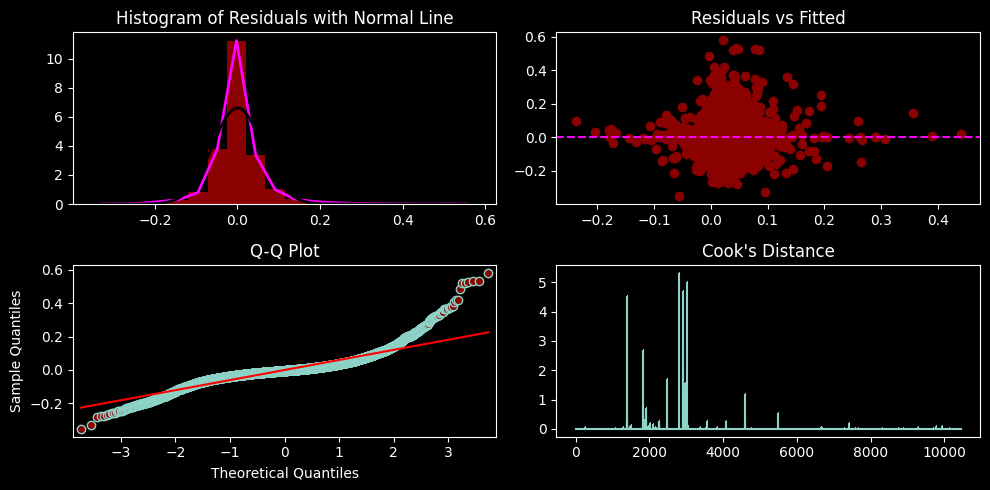

In [48]:
linear = build_ols(sm.add_constant(X_pca), y_train)
print(linear.summary())
graphic_diagnostic(linear)

##### 2.3.3 [ IGNORE NOW ] Remove extreme values (sample) of y

In [21]:
# 
train_filter = remove_extreme_y(train, len(X_train)*0.05)

# split X, y
X_train, y_train = split_X_y(train_filter)
X_test, y_test = split_X_y(test)

# fit linear
linear_reg = fit_linear(X_train, y_train)

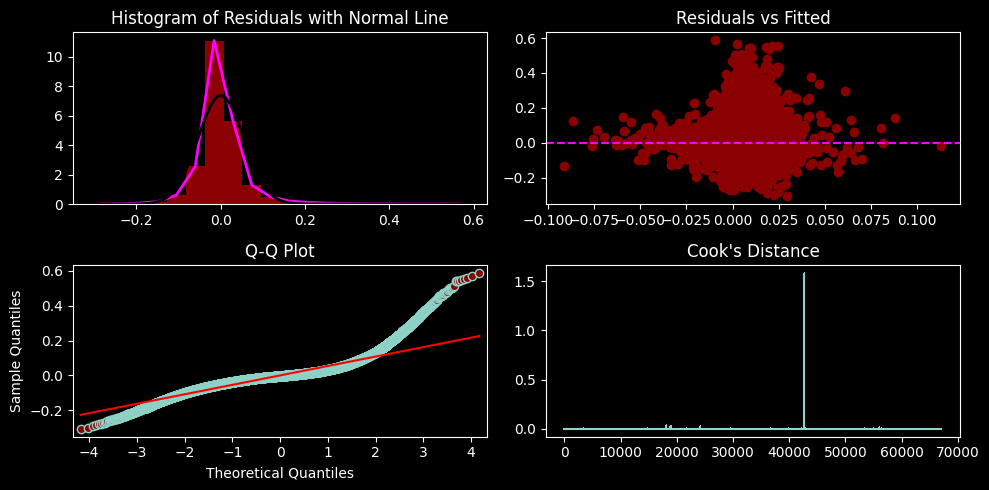

In [22]:
# Plot normality
graphic_diagnostic(linear_reg)

##### 2.3.4 Fit HAC

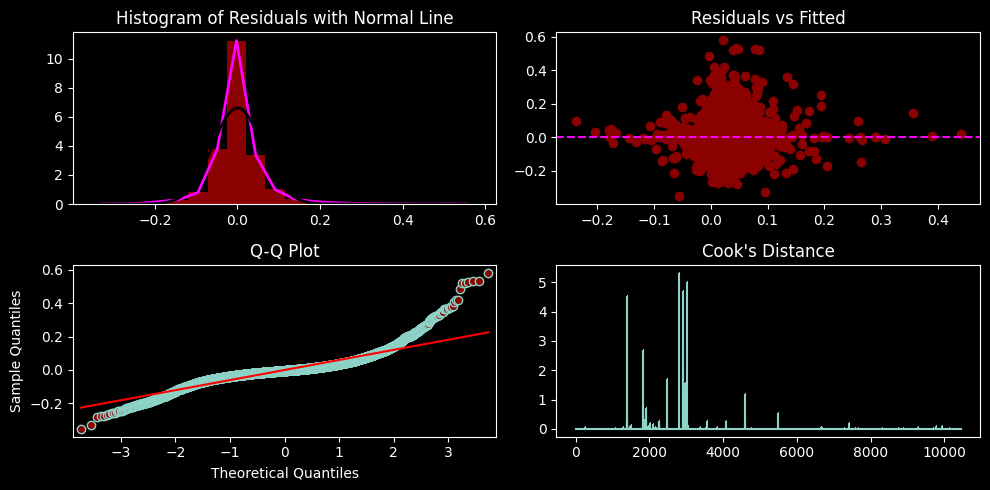

Dep. Variable:,return,R-squared:,0.112
Model:,OLS,Adj. R-squared:,0.082
Method:,Least Squares,F-statistic:,182.6
Date:,"Tue, 26 Dec 2023",Prob (F-statistic):,0.00
Time:,16:10:12,Log-Likelihood:,14521.
No. Observations:,10447,AIC:,-2.835e+04
Df Residuals:,10100,BIC:,-2.583e+04
Df Model:,346,,
Covariance Type:,HC0,,


In [49]:
# use HC0
linear_reg = build_ols(sm.add_constant(X_pca), y_train, HC = 'HC0')
graphic_diagnostic(linear_reg)
linear_reg.summary().tables[0]

##### 2.3.5 Weighted Least Square with HC0

In [50]:
from numpy.linalg import inv
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

# split X, y
X_train, y_train = split_X_y(train)
X_test, y_test = split_X_y(test)

linear_reg_weighted = build_wls(sm.add_constant(X_selected_bic), y_train, "HC0")

print(linear_reg.summary())
print(linear_reg_weighted.summary())
        

building wls
                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     182.6
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:10:24   Log-Likelihood:                 14521.
No. Observations:               10447   AIC:                        -2.835e+04
Df Residuals:                   10100   BIC:                        -2.583e+04
Df Model:                         346                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.001     23

<font color=#800000>ERROR</font> NOTE: Covariance matrix for residuals

In [ ]:
def weight_of_WLS(X_train, linear_reg):
    # The residuals and their variance-covariance matrix
    # http://www.stat.ucla.edu/~nchristo/introeconometrics/introecon_hat.pdf
    # Unable to allocate 33.5 GiB for an array with shape (67092, 67092) and data type float64

    X_train_array = np.array(X_train).astype(np.float32)
    H = X_train_array @ inv(X_train_array.T @ X_train_array) @ X_train_array.T 
    I = np.eye(H.shape[0], dtype=np.float16)

    n = X_train.shape[0]
    k = X_train.shape[1]
    residuals_var_hat = (1/(n - k - 1))*(sum(linear_reg.resid**2))

    # V: residuals_covar_matrix_hat
    V = residuals_var_hat*(I - H)

    # V = KK
    K = np.linalg.cholesky(V)

    return K

## 3. Factors Research (Later)


### 2.1 Industry Factors
- 2.1.1 Ignore
- 2.1.2 One hot Encoding
- 2.1.3 Fit linear regression sorted by industry
### 2.2 More factors
- 2.2.1 [Technical indicators](https://www.ig.com/cn/trading-strategies/10-trading-indicators-every-trader-should-know-221027)
- 2.2.2 Macro data
- 2.2.3 Lag Operators

In [8]:
data_cross_section.mdate = pd.to_datetime(data_cross_section.mdate, utc =True)
predictive_factor = data_cross_section[['mdate','coid','YoY_Monthly_Sales']].\
                            set_index(['mdate','coid']).\
                            unstack('coid')
predictive_factor = predictive_factor.stack()
pricing = data_cross_section[['mdate','coid','Open']].set_index(['mdate','coid']).iloc[1:].\
                                              unstack('coid')['Open']
pricing = pricing.shift(-1)
pricing.head(3)

coid,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
mdate,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,43.25,42.95,19.20,23.55,12.60,19.85,18.1,22.35,37.15,51.00,...,22.55,40.7,16.15,12.05,9.85,95.0,21.05,110.0,34.30,10.20
2021-01-05 00:00:00+00:00,43.10,42.95,19.10,23.30,12.30,19.85,17.9,21.90,36.65,50.50,...,22.60,40.9,16.15,11.95,9.91,95.7,21.10,111.0,33.60,10.20
2021-01-06 00:00:00+00:00,42.95,43.30,18.75,22.80,12.05,19.70,18.0,21.30,36.00,49.75,...,22.65,40.4,16.00,11.95,9.97,94.8,20.45,107.0,31.65,10.35


### 2.1 Industry: Encoding

2.1.1 One hot encoding

In [70]:
def one_hot_encode(data, col):
    one_hot_encoded = pd.get_dummies(data[col], prefix='Category')
    data = pd.concat([data, one_hot_encoded], axis=1)
    return data

# one hot 
data_week_return = data_week_backup.copy()
data_week_return = one_hot_encode(data_week_return, "Industry_Eng")
X, y = split_X_y(data_week_return)
n = len(y)
k = X.shape[1] - 1 # Exclude the constant term

linear_reg = fit_linear(X, y)
linear_reg.summary()
r2_onehotencoding = linear_reg.rsquared
adj_r2_onehotencoding = linear_reg.rsquared_adj
adj_r2_onehotencoding

0.003916333246785864

2.3.2 Predict with group data by industry

In [65]:
def r_squared_by_distinct_industry(data_week_return):
    r_2 = []
    adj_r_2 = []
    num_coid = []
    for industry in data_week_return["Industry_Eng"].unique():
        data_1_industry = data_week_return[data_week_return["Industry_Eng"] == industry]
        X, y = split_X_y(data_1_industry)
        linear_reg = fit_linear(X, y)
        
        n = len(y)
        k = X.shape[1] - 1 # Exclude the constant term
        if n > k:
            adjusted_r_squared = linear_reg.rsquared_adj
            r_2.append(linear_reg.rsquared)
            adj_r_2.append(adjusted_r_squared)
            num_coid.append(X.shape[0])
            
    return r_2, adj_r_2, num_coid
        

In [66]:
data_week_return = data_week_backup.copy()
r_2, adj_r_2, num_coid = r_squared_by_distinct_industry(data_week_return)

In [68]:
adj_r2_ignore_industry, adj_r2_onehotencoding

(0.003916333246785864, 0.003916333246785864)

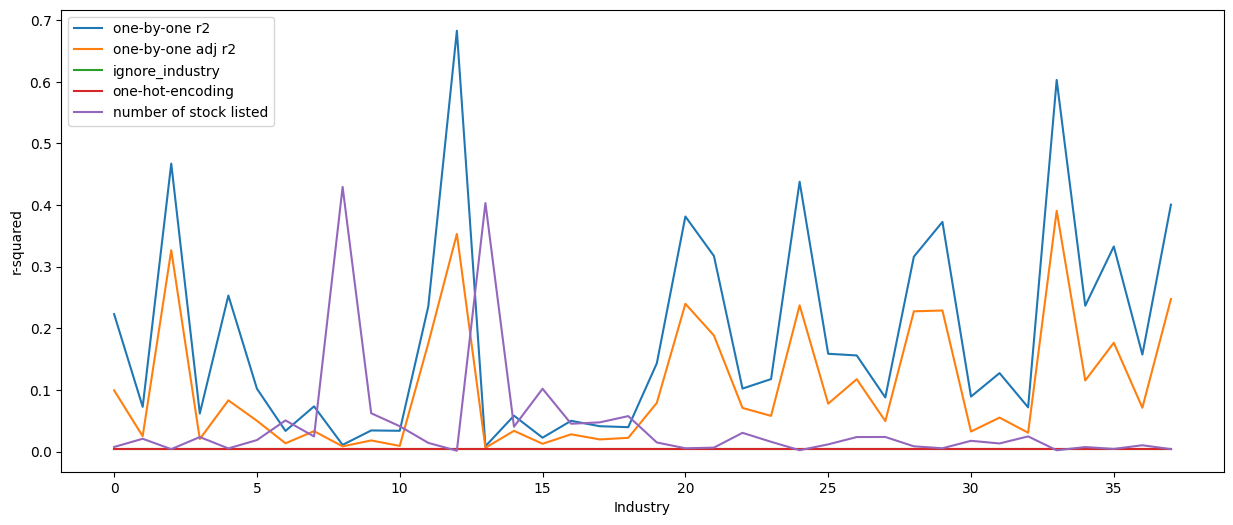

(0.0036269006030524853, 0.003916333246785864, 0.10601852553640334)

In [91]:
plt.figure(figsize=(15, 6))
plt.plot(r_2, label = "one-by-one r2")
plt.plot(adj_r_2, label = "one-by-one adj r2")
plt.plot([adj_r2_ignore_industry]*len(r_2), label = "ignore_industry")
plt.plot([adj_r2_onehotencoding]*len(r_2), label = "one-hot-encoding")
plt.plot([i/120000 for i in num_coid], label = "number of stock listed")
plt.xlabel("Industry")
plt.ylabel("r-squared")
plt.legend()
plt.show()
adj_r2_ignore_industry, adj_r2_onehotencoding, np.mean(adj_r_2)

### 2.2 More Variables

In [76]:
import talib
# use day data
data_cross_section.head()

,coid,mdate,Industry_Eng,Last_Bid,Volume_1000_Shares,PBR_TWSE,Dividend_Yield_TWSE,Cash_Dividend_Yield_TEJ,Open,Close,...,Total_Interest_Income_A,Total_Interest_Income_Q,Total_Interest_Income_TTM,Sales_Growth_Rate_A,Sales_Growth_Rate_Q,Sales_Growth_Rate_TTM,Total_Operating_Cost_A,Total_Operating_Cost_Q,Total_Operating_Cost_TTM,Adj Close
0,1101,2021-01-04 00:00:00+00:00,M1100 Cement,43.20,13744.0,1.32,6.94,5.4473,43.20,43.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.316043
1,1101,2021-01-05 00:00:00+00:00,M1100 Cement,43.10,16631.0,1.32,6.96,5.4599,43.25,43.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.234293
2,1101,2021-01-06 00:00:00+00:00,M1100 Cement,42.90,19007.0,1.32,6.98,5.4790,43.10,42.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.111668
3,1101,2021-01-07 00:00:00+00:00,M1100 Cement,42.85,21050.0,1.31,7.00,5.4918,42.95,42.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.029918
4,1101,2021-01-08 00:00:00+00:00,M1100 Cement,42.90,17406.0,1.32,6.98,5.4790,42.90,42.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.111668


#### 2.4.1 KD

Problems here\
- need about 7 hours to get all kds for each companies => set process time at most 1 hours; regression analysis from these data.
    
KD指標是技術分析常見的指標之一，主要用於判斷股價當前的強弱程度與可能反轉的時機。KD指標的數值介於0-100，一般以50作為分水嶺，當指標大於50時，表示股價處於強勢階段；反之，當股價小於50時，股價屬於弱勢階段。另外，當KD指標小於20時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當KD指標大於80時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。

KD指標的計算流程:

- RSV = ((當日收盤價-近N日的最低價)/(近N日的最高價-近N日的最低價))*100
- K值 = 昨日K值 × (2/3) + 當日RSV × (1/3)
- D值 = 昨日D值 × (2/3) + 當日K值 × (1/3)

從算式來看，可以把RSV解讀成當日股價相較於近N日 (本文N = 9)股價，是屬於較強勢還是弱勢。K值，又被稱為快線，因為受到當日股價強弱的影響較大；而D值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。

本文採用KD指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測:
- K ≤ 20，買入，因其代表股價處於較弱、市場過冷
- K ≥ 80，賣出，代表市場過熱，因此選擇獲利了結

In [88]:
import time

# Calculate KDJ
def KD(data):
    
    start_time = time.time()

    data_kd = pd.DataFrame()

    print(len(data["coid"].unique()))
    
    for k, coid in enumerate(data["coid"].unique()):
        gc.collect()

        # time limits
        if time.time() - start_time > 3600:
            print("Time limit exceeded. Breaking.")
            print(f"Elapsed Time: {time.time() - start_time} seconds")
            break

        print(f"{k}: {coid}")
        data_coid = data[data["coid"] == coid].copy()
        kdj_values = talib.STOCH(data_coid['High'].values,
                        data_coid['Low'].values,
                        data_coid['Close'].values,
                        fastk_period=9,
                        slowk_period=3,
                        slowd_period=3)
        data_coid["%K"] = kdj_values[0]
        data_coid["%D"] = kdj_values[1]
        data_coid["J"] = 3 * data_coid["%K"] - 2 * data_coid["%D"]

        data_kd = pd.concat([data_kd, data_coid], axis=1)

    data_kd.dropna(inplace=True)
    with open("data/kd.pk", "wb") as f:
        pickle.dump(data_kd, f)

    return data_kd

# pipeline of add indicators
def pipeline_add_technical_indicators(
                            data,        # daily data 
                            kd = True):
    if kd == True:
        kd = KD(data)
    return kd

```
MemoryError: Unable to allocate 4.32 GiB for an array with shape (11160, 51912) and data type float64
```

In [89]:
data = data_backup.copy()
kd = pipeline_add_technical_indicators(
                        data,        # daily data 
                        kd = True)

1695
0: 1101
1: 1102
2: 1103
3: 1104
4: 1108
5: 1109
6: 1110
7: 1201
8: 1203
9: 1210
10: 1213
11: 1215
12: 1216
13: 1217
14: 1218
15: 1219
16: 1220
17: 1225
18: 1227
19: 1229
20: 1231
21: 1232
22: 1233
23: 1234
24: 1235
25: 1236
26: 1240
27: 1259
28: 1264
29: 1268
30: 1301
31: 1303
32: 1304
33: 1305
34: 1307
35: 1308
36: 1309
37: 1310
38: 1312
39: 1313
40: 1314
41: 1315
42: 1316
43: 1319
44: 1321
45: 1323
46: 1324
47: 1325
48: 1326
49: 1336
50: 1339
51: 1342
52: 1402
53: 1409
54: 1410
55: 1413
56: 1414
57: 1416
58: 1417
59: 1418
60: 1419
61: 1423
62: 1432
63: 1434
64: 1435
65: 1436
66: 1437
67: 1438
68: 1439
69: 1440
70: 1441
71: 1442
72: 1443
73: 1444
74: 1445
75: 1446
76: 1447
77: 1449
78: 1451
Time limit exceeded. Breaking.
Elapsed Time: 3752.3113062381744 seconds


TypeError: dump() missing required argument 'file' (pos 2)

In [ ]:
data = data_backup.copy()


with open("data/kd", "rb") as f:
    kd = pickle.dump(f)

data_kd

## 4. Rolling Prediction


### Rolling Prediction
- result: result/ols(or wls)

In [3]:
from itertools import product
from rolling import *
from rolling import Rolling_Prediction
min(data_clean['mdate'])

Timestamp('2021-04-16 00:00:00')

In [ ]:
# ***********************
# fixed here
transform_method = \
    {
    'scaler': 'MinMax',        # 'Standard', 'MinMax'
    'winsor': True       # False
    }
# ***********************

mode = \
    {
    'sort_industry': False, 
    'kernel': False,
    'selected_stock': 'percent',
    'long_ratio': 0.5,
    'decision_trade': 80
    }
model = 'wls'

rp = Rolling_Prediction(
    data_clean, 
    20,                 # train size
    model, 
    mode, 
    transform_method)
results = rp.rolling_predict()
(cum_asset_portfolio_market, portfolio_ret, market_ret) = results

Select mode iteratively

In [ ]:
# ITERATION OF DIFFERENT COMBINATION IN MODE
# 1. Select specific keys for which you want to generate combinations
# 2. Extract values for selected keys
# 3. Generate all combinations

# mode
    # sort_industry: True or False
    # poly_degree: None or int
    # kernel:True or False 
    # selected_stock: 'percent' or 'top'. 
    # decision_trade: If percentile: long {80} short {1 - 80}, If top_n: long top_n short top_n
mode = \
    {
    'sort_industry': [True, False], 
    'poly_degree': [None], 
    'kernel': [False],
    'selected_stock': ['percent', 'top'],
    'long_ratio': [0.5, 1],
    }
# utils -> transform_preprocess
transform_method = \
    {
    'scaler': 'Standard', # 'MinMax'
    'winsor': True        # False
    }


if mode['selected_stock'] == 'percent':
    mode['decision_trade'] = 80  
elif mode['selected_stock'] == 'top':
    mode['decision_trade'] = 10 

selected_keys = list(mode.keys())
selected_values = [mode[key] for key in selected_keys]
combinations = list(product(*selected_values))


Result

In [59]:
# Read stored result in result/~
# mode
mode = \
    {
    'sort_industry': False, 
    'kernel': False,
    'selected_stock': 'percent',
    'long_ratio': 0.5,
    'decision_trade': 80
    }

model = "wls"

# filename
filename = ''
for i in list(mode.keys()):
    value = mode[i]
    filename += i + '-' + str(value) + ' '

# load result
with open(f'result/{model}/mode_[{filename}].pk', 'rb') as f:
    (mode, (result)) =  pickle.load(f)
cum_asset_portfolio_market, portfolio_ret, market_ret = result
cum_asset_portfolio_market.set_index(["date"], inplace=True)

In [62]:

cum_port = np.cumprod([1 + i + .004 for i in portfolio_ret])
cum_port = pd.DataFrame(cum_port).set_index(cum_asset_portfolio_market.index)
inv_cum_port = np.cumprod([(-1)*i + 1 - .008 for i in portfolio_ret])
inv_cum_port = pd.DataFrame(inv_cum_port).set_index(cum_asset_portfolio_market.index)

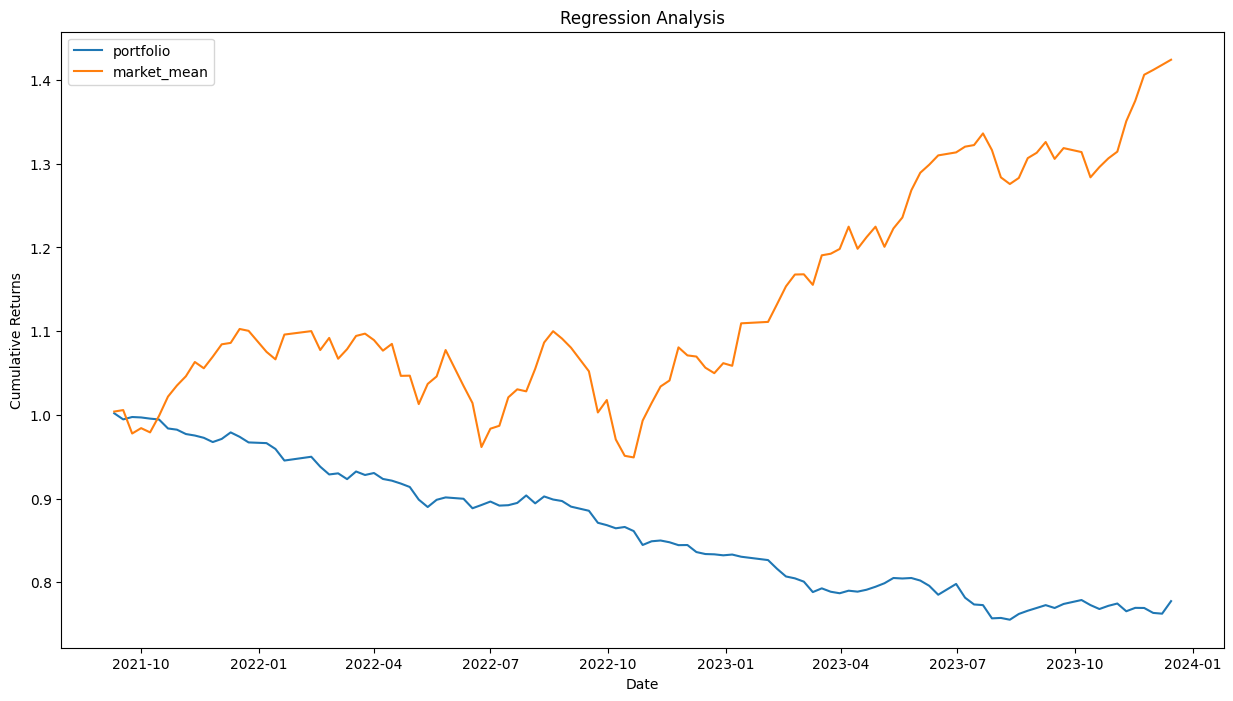

In [65]:
# cum_asset_portfolio_market["cum_asset"]

plt.figure(figsize=(15, 8))
plt.plot(cum_asset_portfolio_market["cum_asset"], label = "portfolio")
plt.plot(cum_asset_portfolio_market["market"], label = "market_mean")
# plt.plot(inv_cum_port, label = "inverse_portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
"""
plt.text(19500, 1.05, 
f'''
portfolio mean {np.mean(portfolio_ret)*52: .5f} (anualise)
portfolio var {np.std(portfolio_ret)*(52**(0.5)): .5f} (anualise)
portfolio sharpe ratio {np.mean(portfolio_ret)/np.std(portfolio_ret)*(52**(0.5)): .5f} (anualise)
market mean  {np.mean(market_ret)*52: .5f} (anualise)
market var {np.std(market_ret)*(52**(0.5)): .5f} (anualise)
market sharpe ratio {np.mean(market_ret)/np.std(market_ret)*(52**(0.5)): .5f} (anualise)
''', 
fontsize = 12,
color = 'Magenta')
"""
plt.title(f'Regression Analysis')
plt.legend()
plt.show()